# Creating and defending from adversarial examples

In [1]:
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import transforms, datasets
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
import torch
import olympic

In [2]:
import sys
from typing import Union, Callable, Tuple
sys.path.append('../adversarial/')
sys.path.append('../')
from functional import boundary, iterated_fgsm, local_search, pgd

In [3]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
    
with plt.style.context('ggplot'):
    COLOURS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train = datasets.MNIST('../data/', train=True, transform=transform, download=True)
val = datasets.MNIST('../data/', train=False, transform=transform, download=True)

train_loader = DataLoader(train, batch_size=128, num_workers=cpu_count())
val_loader = DataLoader(val, batch_size=128, num_workers=cpu_count())

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 1024)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

In [6]:
model = Net().to(DEVICE)
optimiser = optim.SGD(model.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()

In [7]:
history_natural = olympic.fit(
    model,
    optimiser,
    loss_fn,
    dataloader=train_loader,
    epochs=20,
    metrics=['accuracy'],
    prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)),
    callbacks=[
        olympic.callbacks.Evaluate(val_loader),
        olympic.callbacks.ReduceLROnPlateau(patience=5)
    ]
)

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Begin training...


Epoch 20: 100%|██████████| 469/469 [00:04<00:00, 116.75it/s, loss=0.0135, accuracy=0.996, val_loss=0.0274, val_accuracy=0.991]

Finished.


In [8]:
olympic.evaluate(model, val_loader, metrics=['accuracy'],
                 prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)))

{'val_accuracy': 0.9908}

# Iterative adversarial attacks
Here I will show how to use an iterative attack method to create adversarial examples. I will visualise examples for an L2 bounded and Linf bounded adversaries and calculate accuracies against different size adversarial perturbations.

In [9]:
def visualise_adversarial_examples(model, x, y, l2_eps=2.0, linf_eps=0.2):
    x = x.unsqueeze(0).to(DEVICE)
    y = y.unsqueeze(0).to(DEVICE)
    x_adv_l2 = pgd(model, x, y, torch.nn.CrossEntropyLoss(), k=120, step=0.1, eps=l2_eps, norm=2)
    x_adv_linf = iterated_fgsm(model, x, y, torch.nn.CrossEntropyLoss(), k=60, step=0.01, eps=linf_eps, norm='inf')
    
    y_pred = model(x)
    y_pred_l2 = model(x_adv_l2)
    y_pred_linf = model(x_adv_linf)
    
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    
    axes[0].imshow(x[0, 0].cpu().numpy(), cmap='gray')
    axes[0].set_title(
        f'Natural, '
        f'P({ y_pred.argmax(dim=1).item()}) = '
        f'{np.round(y_pred.softmax(dim=1)[0, y_pred.argmax(dim=1).item()].item(), 3)}')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    
    axes[1].imshow(x_adv_l2[0, 0].cpu().numpy(), cmap='gray')
    axes[1].set_title(
        f'$L^2$ adversary, '
        f'eps={l2_eps}, '
        f'P({y_pred_l2.argmax(dim=1).item()}) = '
        f'{np.round(y_pred_l2.softmax(dim=1)[0, y_pred_l2.argmax(dim=1).item()].item(), 3)}')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    
    axes[2].imshow(x_adv_linf[0, 0].cpu().numpy(), cmap='gray')
    axes[2].set_title(
        '$L^{\infty}$ adversary, '
        f'eps={linf_eps}, '
        f'P({y_pred_l2.argmax(dim=1).item()}) = '
        f'{np.round(y_pred_linf.softmax(dim=1)[0, y_pred_linf.argmax(dim=1).item()].item(), 3)}')
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    
    
    plt.show()

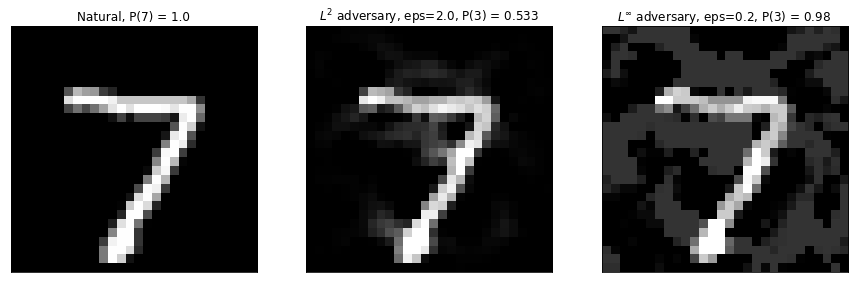

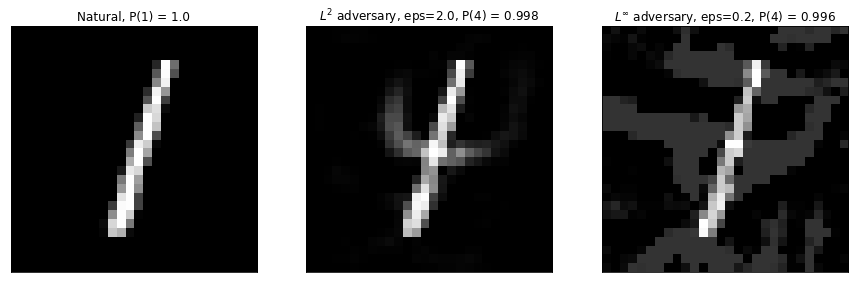

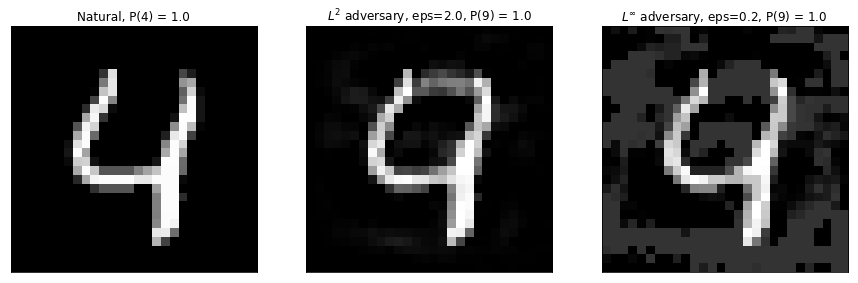

In [10]:
visualise_adversarial_examples(model, *val[0])
visualise_adversarial_examples(model, *val[2])
visualise_adversarial_examples(model, *val[4])

Let's quantify this by measuring the validation accuracy of the model with different size perturbations.

### Quantifying adversarial accuracy

In [11]:
def evaluate_against_adversary(model, k, eps, step, norm):
    total = 0
    acc = 0
    for x, y in val_loader:
        total += x.size(0)
        
        if norm == 2:
            x_adv = pgd(
                model, x.to(DEVICE), y.to(DEVICE), torch.nn.CrossEntropyLoss(), k=k, step=step, eps=eps, norm=2)
        elif norm == 'inf':
            x_adv = iterated_fgsm(
                model, x.to(DEVICE), y.to(DEVICE), torch.nn.CrossEntropyLoss(), k=k, step=step, eps=eps, norm='inf')
        
        y_pred = model(x_adv)

        acc += olympic.metrics.accuracy(y.to(DEVICE), y_pred) * x.size(0)

    return acc/total

In [12]:
pgd_attack_range = np.arange(0.0, 6.1, 1./3)
pgd_acc = []
for eps in pgd_attack_range:
    pgd_acc.append(evaluate_against_adversary(model, k=40, eps=eps, step=0.1, norm=2))

In [13]:
iter_fgsm_attack_range = np.arange(0.0, 0.52, 0.025)
iter_fgsm_acc = []
for eps in iter_fgsm_attack_range:
    iter_fgsm_acc.append(evaluate_against_adversary(model, k=40, step=0.01, eps=eps, norm='inf'))

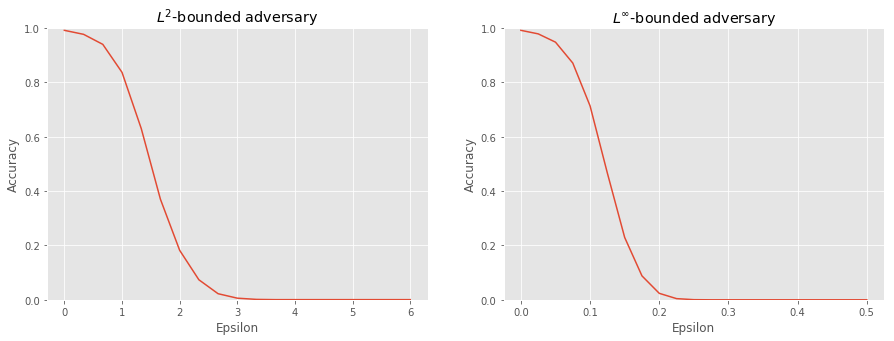

<Figure size 1008x504 with 0 Axes>

In [14]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    plt.figure(figsize=(14,7))
    
    axes[0].set_title('$L^2$-bounded adversary')
    axes[0].plot(pgd_attack_range, pgd_acc)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epsilon')
    axes[0].set_ylim((0,1))
    
    axes[1].set_title('$L^{\infty}$-bounded adversary')
    axes[1].plot(iter_fgsm_attack_range, iter_fgsm_acc)
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epsilon')
    axes[1].set_ylim((0,1))
    
    plt.show()

# Adversarial Training
Instead of minising the regular loss

$\mathop{}{\mathbb{E}}_f$

minimise the adversarial loss

$\mathop{}{\mathbb{E}}_f$

In [15]:
def adversarial_training(model, optimiser, loss_fn, x, y, epoch, adversary, k, step, eps, norm):
    """Performs a single update against a specified adversary"""
    model.train()

    # Adversial perturbation
    x_adv = adversary(model, x, y, loss_fn, k=k, step=step, eps=eps, norm=norm)

    optimiser.zero_grad()
    y_pred = model(x_adv)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimiser.step()

    return loss, y_pred

In [16]:
adv_model_linf = Net().to(DEVICE)
optimiser = optim.SGD(adv_model_linf.parameters(), lr=0.1)
training_history_linf = olympic.fit(
    adv_model_linf,
    optimiser,
    nn.CrossEntropyLoss(),
    dataloader=train_loader,
    epochs=50,
    metrics=['accuracy'],
    prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)),
    update_fn=adversarial_training,
    update_fn_kwargs={'adversary': iterated_fgsm,'k': 40, 'step': 0.01, 'eps': 0.3, 'norm': 'inf'},
    callbacks=[
        olympic.callbacks.Evaluate(val_loader),
        olympic.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_delta=0.005, monitor='val_accuracy')
    ]
)

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Begin training...


Epoch 50: 100%|██████████| 469/469 [00:38<00:00,  6.90it/s, loss=0.247, accuracy=0.918, val_loss=0.0652, val_accuracy=0.98]

Finished.


In [17]:
adv_model_l2 = Net().to(DEVICE)
optimiser = optim.SGD(adv_model_l2.parameters(), lr=0.1)
training_history_l2 = olympic.fit(
    adv_model_l2,
    optimiser,
    nn.CrossEntropyLoss(),
    dataloader=train_loader,
    epochs=50,
    metrics=['accuracy'],
    prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)),
    update_fn=adversarial_training,
    update_fn_kwargs={'adversary': pgd, 'k': 40, 'step': 0.1, 'eps': 3.0, 'norm': 2},
    callbacks=[
        olympic.callbacks.Evaluate(val_loader),
        olympic.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_delta=0.005, monitor='val_accuracy')
    ]
)

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Begin training...


Epoch 50: 100%|██████████| 469/469 [00:49<00:00,  5.25it/s, loss=1.08, accuracy=0.549, val_loss=0.281, val_accuracy=0.966]

Finished.


In [18]:
# Save hardened models
torch.save(adv_model_linf, '../models/mnist_iterated_fgsm_k=40_step=0.01_eps=0.3.pt')
torch.save(adv_model_l2, '../models/mnist_pgd_k=40_step=0.1_eps=3.0.pt')

/home/oscar/PycharmProjects/adversarial/venv/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [9]:
adv_model_linf = torch.load('../models/mnist_iterated_fgsm_k=40_step=0.01_eps=0.3.pt').to(DEVICE)
adv_model_l2 = torch.load('../models/mnist_pgd_k=40_step=0.1_eps=3.0.pt').to(DEVICE)

# Test hardened models

In [20]:
pgd_acc_linf = []
pgd_acc_l2 = []
for eps in pgd_attack_range:
    pgd_acc_linf.append(evaluate_against_adversary(adv_model_linf, k=120, eps=eps, step=0.25, norm=2))
    pgd_acc_l2.append(evaluate_against_adversary(adv_model_l2, k=120, eps=eps, step=0.25, norm=2))

In [21]:
iter_fgsm_acc_linf = []
iter_fgsm_acc_l2 = []
for eps in iter_fgsm_attack_range:
    iter_fgsm_acc_linf.append(
        evaluate_against_adversary(adv_model_linf, k=120, step=0.01, eps=eps, norm='inf'))
    iter_fgsm_acc_l2.append(
        evaluate_against_adversary(adv_model_l2, k=120, step=0.01, eps=eps, norm='inf'))

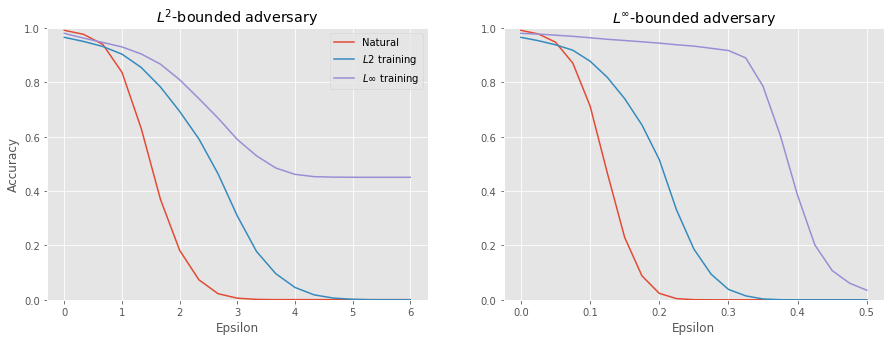

<Figure size 1008x504 with 0 Axes>

In [22]:
with plt.style.context('ggplot'):
    
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    plt.figure(figsize=(14,7))
    
    axes[0].set_title('$L^2$-bounded adversary')
    axes[0].plot(pgd_attack_range, pgd_acc, label='Natural')
    axes[0].plot(pgd_attack_range, pgd_acc_l2, label='$L2$ training')
    axes[0].plot(pgd_attack_range, pgd_acc_linf, label='$L{\infty}$ training')
#     axes[0].vlines([3], 0, 1, colors=COLOURS[1], linestyle='--')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epsilon')
    axes[0].set_ylim((0,1))
    axes[0].legend()
    
    axes[1].set_title('$L^{\infty}$-bounded adversary')
    axes[1].plot(iter_fgsm_attack_range, iter_fgsm_acc)
    axes[1].plot(iter_fgsm_attack_range, iter_fgsm_acc_l2, label='$L2$ training')
    axes[1].plot(iter_fgsm_attack_range, iter_fgsm_acc_linf, label='$L{\infty}$ training')
#     axes[1].vlines([0.3], 0, 1, colors=COLOURS[2], linestyle='--')
    axes[1].set_xlabel('Epsilon')
    axes[1].set_ylim((0,1))
    
    plt.show()

# Class interpolation
### Untargeted

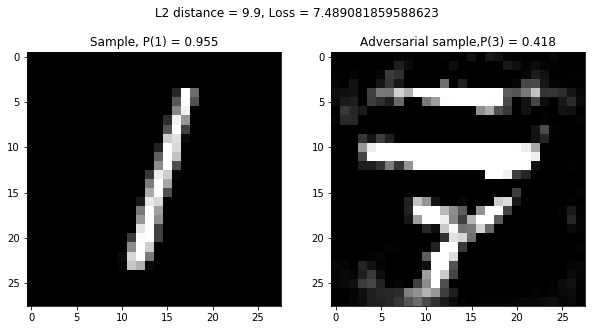

In [16]:
x, y = val[2]
x = x.unsqueeze(0).to(DEVICE)
y = y.unsqueeze(0).to(DEVICE)
# x_adv_pgd_hard = pgd(adv_model_l2, x, y, torch.nn.CrossEntropyLoss(), k=240, step=0.25, eps=9.5, norm=2)
x_adv_pgd_hard = pgd(model, x, y, torch.nn.CrossEntropyLoss(), k=240, step=0.25, eps=10, norm=2)

y_pred = adv_model_l2(x)
y_adv_pred_l2 = adv_model_l2(x_adv_pgd_hard)

fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle(
    f'L2 distance = {np.round((x - x_adv_pgd_hard).norm(2).item(), 2)}, '
    f'Loss = {torch.nn.CrossEntropyLoss()(y_adv_pred_l2, y).item()}'
)
axes[0].imshow(x[0, 0].cpu().numpy(), cmap='gray')
axes[0].set_title(
    f'Sample, '
    f'P({y_pred.argmax(dim=1).item()}) = '
    f'{np.round(y_pred.softmax(dim=1)[0, y_pred.argmax(dim=1).item()].item(), 3)}'
)

axes[1].imshow(x_adv_pgd_hard[0, 0].cpu().numpy(), cmap='gray')
axes[1].set_title(
    'Adversarial sample,'
    f'P({y_adv_pred_l2.argmax(dim=1).item()}) = '
    f'{np.round(y_adv_pred_l2.softmax(dim=1)[0, y_adv_pred_l2.argmax(dim=1).item()].item(), 3)}'
)

plt.show()

Get the classes as it goes through

In [68]:
preds = []
losses = []
eps_range = np.linspace(0, 10, 50)
for eps in eps_range:
    x_adv_pgd_hard = pgd(adv_model_l2, x, y, torch.nn.CrossEntropyLoss(), k=240, step=0.25, eps=eps, norm=2)

    y_adv_pred_l2 = adv_model_l2(x_adv_pgd_hard)
    
    losses.append(torch.nn.CrossEntropyLoss()(y_adv_pred_l2, y).item())
    preds.append(y_adv_pred_l2.softmax(dim=1))

preds = torch.cat(preds).detach().cpu().numpy()

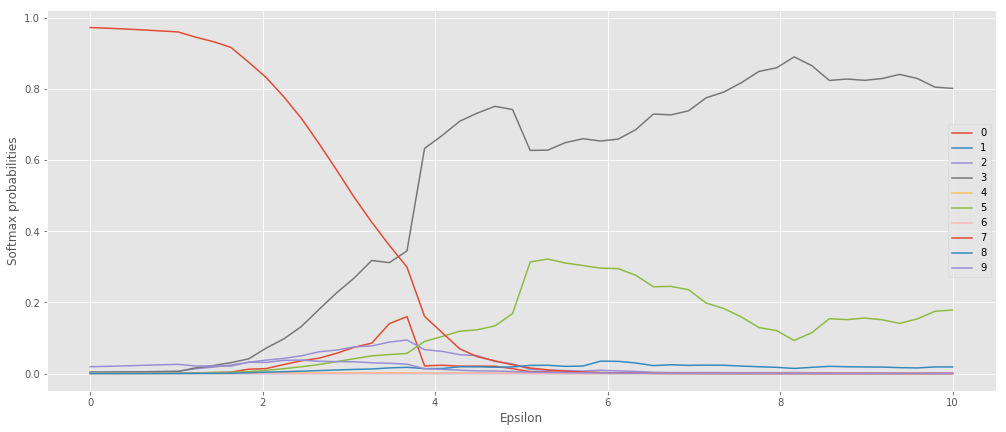

In [70]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(17,7))
    
#     for i in [7, 9, 4, 5, 6]:
    for i in range(10):
        plt.plot(eps_range, preds[:, i], label=i)
            
    plt.legend()
    plt.ylabel('Softmax probabilities')
    plt.xlabel('Epsilon')
    plt.show()

### Targeted

3


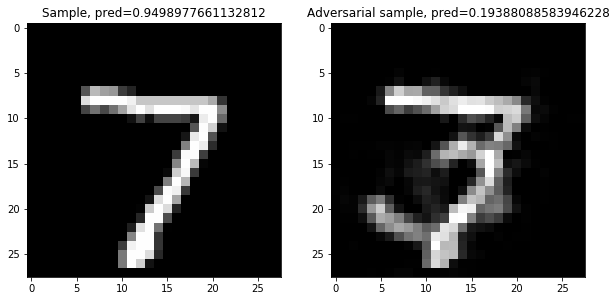

In [27]:
 x_adv_pgd_hard = pgd(adv_model_l2, x, y, torch.nn.CrossEntropyLoss(),
                             k=120, step=0.25, eps=4, norm=2, y_target=torch.Tensor([3]).long().to(DEVICE))
    
print(adv_model_l2(x_adv_pgd_hard).argmax(dim=1).item())
fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].imshow(x[0, 0].cpu().numpy(), cmap='gray')
axes[0].set_title(f'Sample, pred={adv_model_l2(x).softmax(dim=1)[0, y].item()}')

axes[1].imshow(x_adv_pgd_hard[0, 0].cpu().numpy(), cmap='gray')
axes[1].set_title(f'Adversarial sample, pred={adv_model_l2(x_adv_pgd_hard).softmax(dim=1)[0, y].item()}')

plt.show()

In [28]:
def class_interpolations(eps, model_, random=False):
    examples = []
    for i in range(10):
        if i != 7:
            x_adv_pgd_hard = pgd(model_, x, y, torch.nn.CrossEntropyLoss(), random=random,
                             k=120, step=0.1, eps=eps, norm=2, y_target=torch.Tensor([i]).long().to(DEVICE))
            
            examples.append(x_adv_pgd_hard[0, 0].cpu().numpy())
        else:
            examples.append(x[0, 0].cpu().numpy())

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle(f'Interpolating with eps={eps}')
    idx = list(range(10))
    idx.remove(7)

    for i, j in enumerate(idx):
        axes[i // 3, i % 3].set_title(f'{y.item()} -> {j}')
        axes[i // 3, i % 3].imshow(examples[j], cmap='gray')
        axes[i // 3, i % 3].set_xticks([])
        axes[i // 3, i % 3].set_yticks([])

    plt.show()

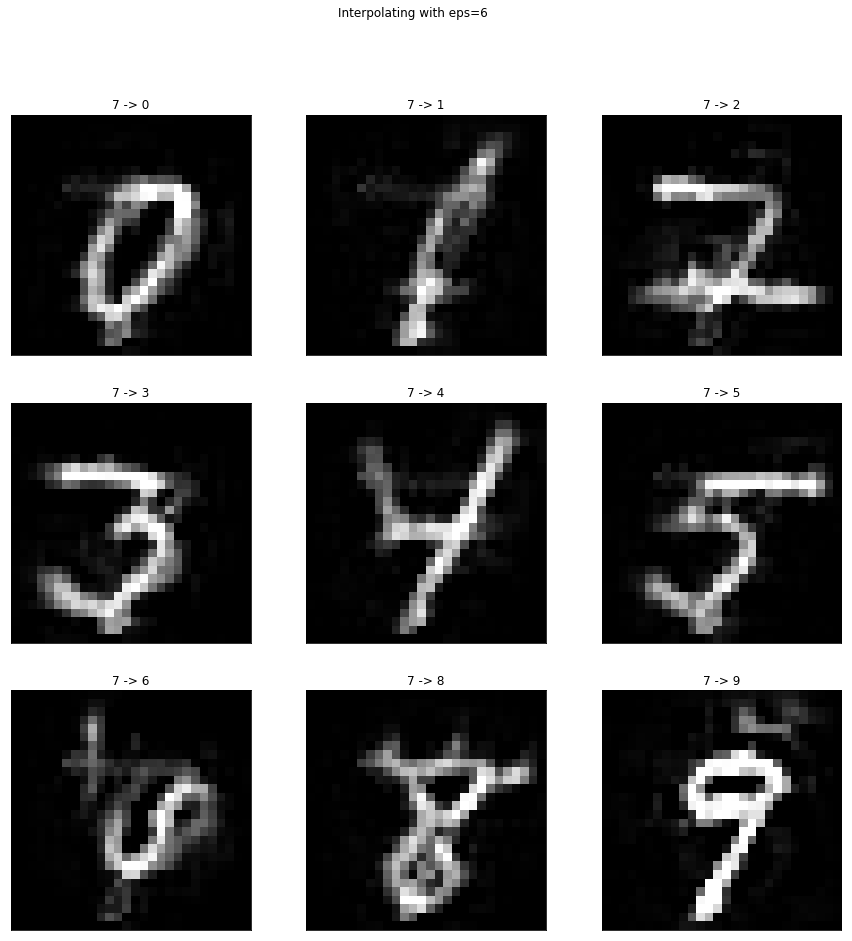

In [29]:
class_interpolations(6, adv_model_l2, random=False)

In [33]:
def smoothly_interpolate(model_, target_class, eps_range):
    examples = []
    fig, axes = plt.subplots(1, len(eps_range), figsize=(5*len(eps_range), 5))
    
    y_target = None if target_class is None else torch.Tensor([target_class]).long().to(DEVICE)
    
    for i, eps in enumerate(eps_range):
        x_adv_pgd_hard = pgd(model_, x, y, torch.nn.CrossEntropyLoss(),
                         k=120, step=0.1, eps=eps, norm=2, y_target=y_target)

        examples.append(x_adv_pgd_hard[0, 0].cpu().numpy())
        
#         axes[i].set_title(f'{eps}')
        axes[i].imshow(x_adv_pgd_hard[0,0].cpu().numpy(), cmap='gray')
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    plt.show()

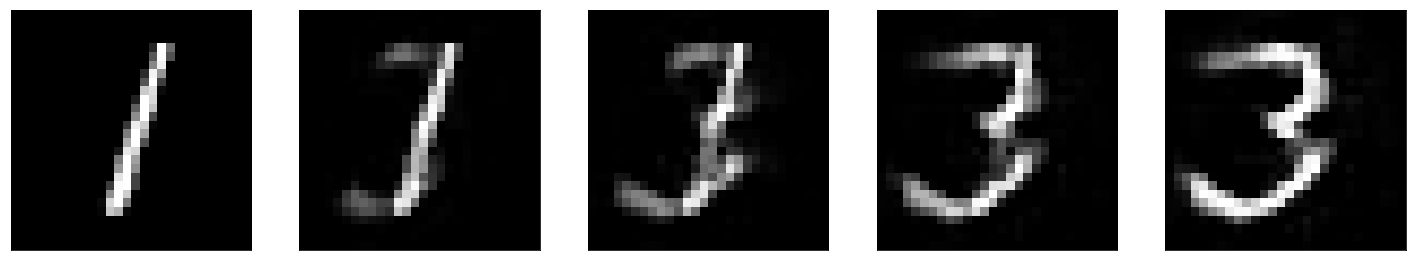

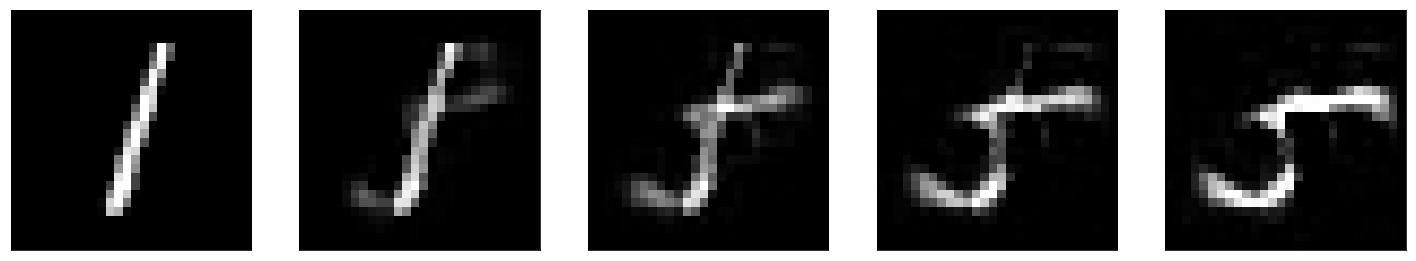

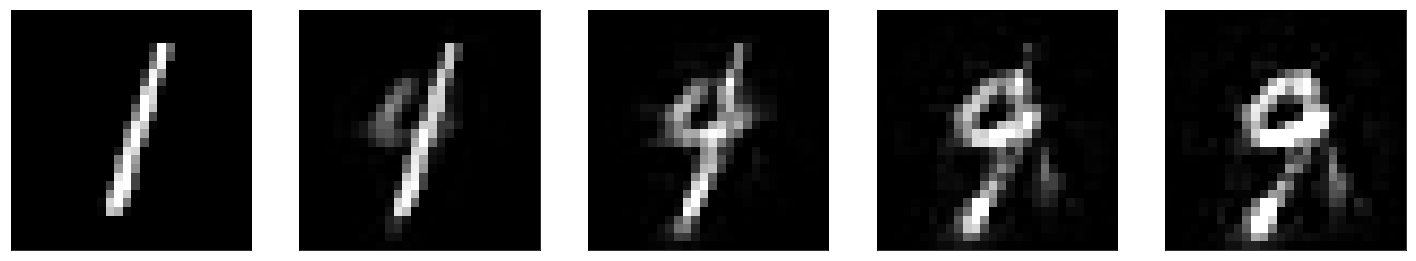

In [34]:
x, y = val[2]
x = x.unsqueeze(0).to(DEVICE)
y = y.unsqueeze(0).to(DEVICE)
smoothly_interpolate(adv_model_l2, 3, np.linspace(0, 7.5, 5))
smoothly_interpolate(adv_model_l2, 5, np.linspace(0, 7.5, 5))
smoothly_interpolate(adv_model_l2, 9, np.linspace(0, 7.5, 5))

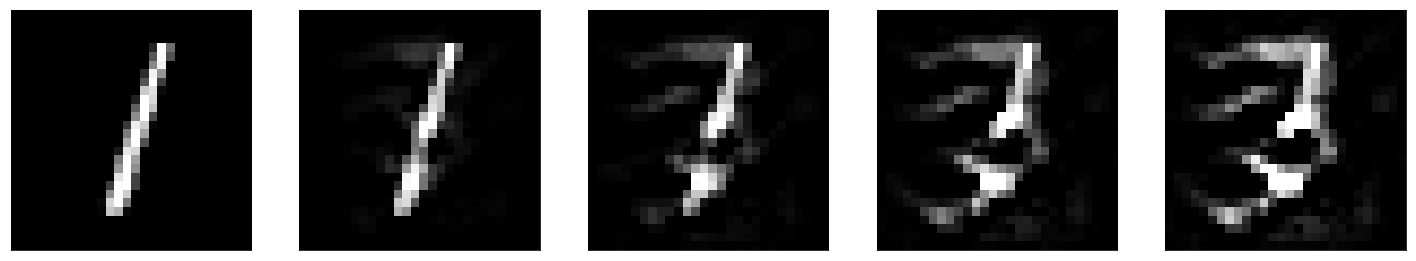

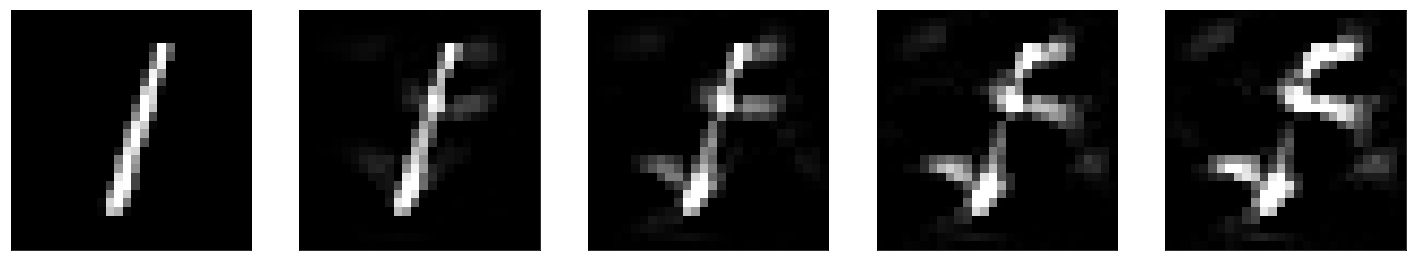

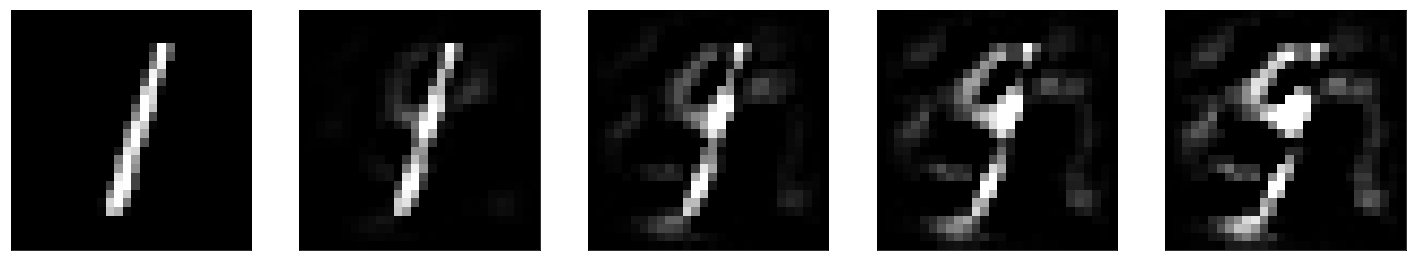

In [37]:
x, y = val[2]
x = x.unsqueeze(0).to(DEVICE)
y = y.unsqueeze(0).to(DEVICE)
smoothly_interpolate(model, 3, np.linspace(0, 6, 5))
smoothly_interpolate(model, 5, np.linspace(0, 6, 5))
smoothly_interpolate(model, 9, np.linspace(0, 6, 5))

Extreme sparsity of Linf model weights

In [38]:
from collections import OrderedDict

In [39]:
adv_model_linf_params = OrderedDict(adv_model_linf.named_parameters())

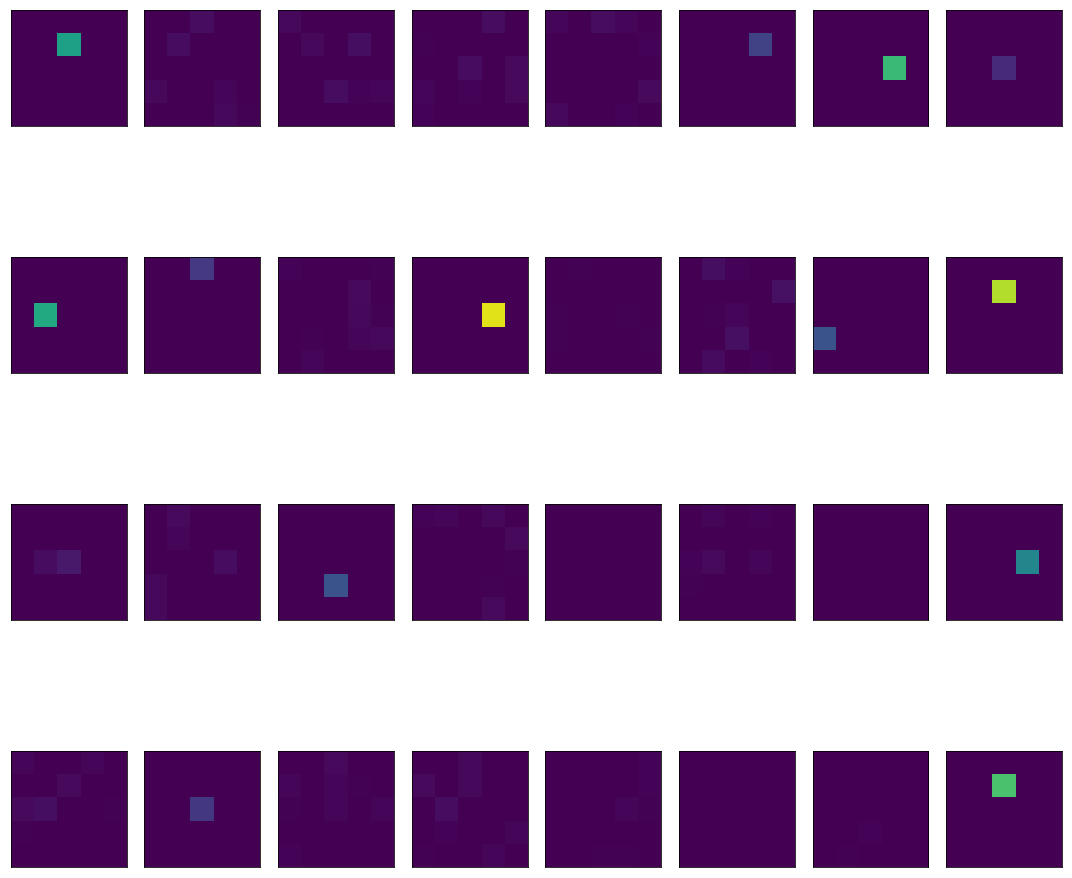

In [42]:
fig, axes = plt.subplots(4, 8, figsize=(15,15))
for i, f in enumerate(adv_model_linf_params['conv1.weight']):
    axes[i // 8, i % 8].imshow(f[0].cpu().detach().numpy(), vmin=0, vmax=4)
    axes[i // 8, i % 8].set_yticks([])
    axes[i // 8, i % 8].set_xticks([])

plt.tight_layout()
plt.show()

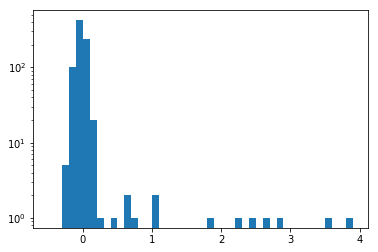

In [35]:
plt.hist(adv_model_linf_params['conv1.weight'].detach().cpu().numpy().flatten(), bins=np.arange(-0.5, 4, 0.1))
plt.yscale('log')
plt.show()

# Garbage examples

In [36]:
x_garbage = torch.zeros((10000, 1, 28, 28)).uniform_(0, 1).to(DEVICE)

y_pred_garbage = model(x_garbage)
y_pred_garbage_l2 = adv_model_l2(x_garbage)
y_pred_garbage_linf = adv_model_linf(x_garbage)

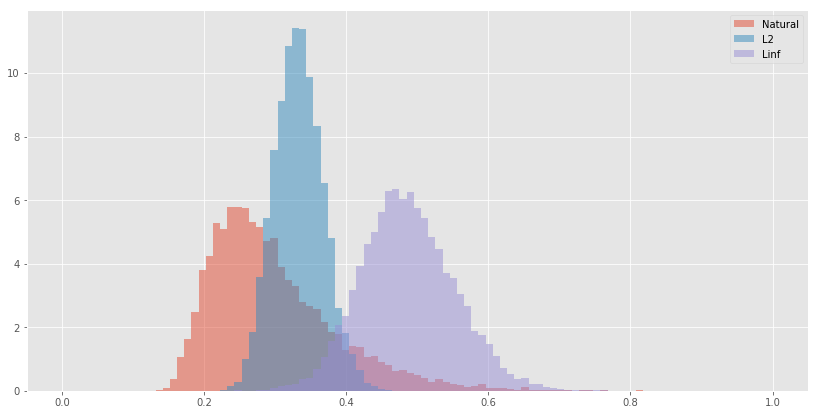

In [37]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(14,7))
    plt.hist(
        y_pred_garbage.softmax(dim=1).max(dim=1)[0].detach().cpu().numpy(),
        alpha=0.5,
        label='Natural',
        bins=np.linspace(0, 1, 100),
        density=True
    )
    plt.hist(
        y_pred_garbage_l2.softmax(dim=1).max(dim=1)[0].detach().cpu().numpy(),
        alpha=0.5,
        label='L2',
        bins=np.linspace(0, 1, 100), density=True
    )
    plt.hist(
        y_pred_garbage_linf.softmax(dim=1).max(dim=1)[0].detach().cpu().numpy(), 
        alpha=0.5,
        label='Linf',
        bins=np.linspace(0, 1, 100), density=True
    )
#     plt.yscale('log')
    plt.legend()
    plt.show()

L2 model shows some sort of robustness against garbage examples.

### Interpretable gradients

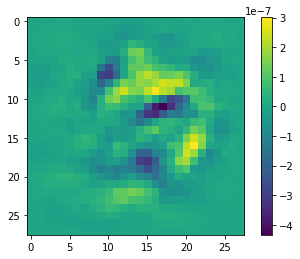

In [38]:
x, y = val[11]
x = x.unsqueeze(0).to(DEVICE).requires_grad_(True)
y = y.unsqueeze(0).to(DEVICE)
y_pred = model(x)
loss = loss_fn(y_pred, y)
loss.backward()
plt.imshow(x.grad[0,0].detach().cpu().numpy())
plt.colorbar()

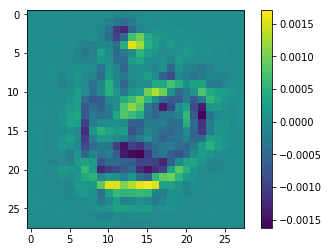

In [39]:
x, y = val[11]
x = x.unsqueeze(0).to(DEVICE).requires_grad_(True)
y = y.unsqueeze(0).to(DEVICE)
y_pred = adv_model_l2(x)
loss = loss_fn(y_pred, y)
loss.backward()
plt.imshow(x.grad[0,0].detach().cpu().numpy())
plt.colorbar()
plt.show()

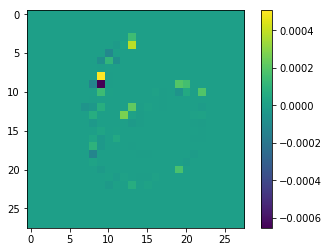

In [40]:
x, y = val[11]
x = x.unsqueeze(0).to(DEVICE).requires_grad_(True)
y = y.unsqueeze(0).to(DEVICE)
y_pred = adv_model_linf(x)
loss = loss_fn(y_pred, y)
loss.backward()
plt.imshow(x.grad[0,0].detach().cpu().numpy())
plt.colorbar()
plt.show()